In [1]:
import collections
from collections import OrderedDict
from matplotlib import pyplot as plt
from matplotlib import cm
import pylab
import math
import numpy as np
from operator import add
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [6]:
class CGR():
    K = 0
    c = None
    h = ""
    Data = ""
    i = 0
    def __init__(self,a):
        self.i=a
    def read_fasta(self,loc):
        f = open(loc)
        s1 = f.read()
        data = "".join(s1.split("\n")[1:])
        head = "".join(s1.split("\n")[0:1])
        return data,head
    
    def count_kmers(self,sequence, k):
        d = collections.defaultdict(int)
        for i in range(len(self.Data)-(k-1)):
            d[sequence[i:i+k]] +=1
        d.pop("N",None)
        return d

    def probabilities(self,kmer_count, k):
        probabilities = collections.defaultdict(float)
        N = len(self.Data)
        for key, value in kmer_count.items():
            probabilities[key] = float(value) / (N - k + 1)
        return probabilities

    def chaos_game_representation(self,probabilities, k):
        array_size = int(math.sqrt(4**k))
        chaos = []
        for i in range(array_size):
            chaos.append([0]*array_size)
        maxx = array_size
        maxy = array_size
        posx = 1
        posy = 1
        for key, value in probabilities.items():
            for char in key:
                if char == "T":
                    posx +=  maxx/2
                elif char == "C":
                    posy += maxy/2
                elif char == "G":
                    posx += maxx/2
                    posy += maxy/2
                maxx /= 2
                maxy /= 2

            chaos[int(posy-1)][int(posx-1)] = value
            maxx = array_size
            maxy = array_size
            posx = 1
            posy = 1
        m = float(np.amax(chaos))
        c = np.array(chaos)/m
        return c

    def load_fasta(self,loc,k):
        data,head = self.read_fasta(loc)
        self.Data = data
        f4 = self.count_kmers(data, k)
        f4_prob = self.probabilities(f4, k)
        chaos_k4 = self.chaos_game_representation(f4_prob, k)
        self.c = chaos_k4
        self.h = head
        return chaos_k4
    
    def show(self):
        plt.figure(figsize=(12,12))
        plt.title('CGR of '+str(self.K)+'-mers for '+self.h[2:])
        plt.pcolor(self.c,cmap=cm.gray_r)#,interpolation = "spline36")
        #pylab.savefig(str(self.i)+".PNG")
        plt.show()
    
    def show_v2(self):
        pylab.figure(figsize=(12,12))
        pylab.title('CGR of '+str(self.K)+'-mers for '+self.h[2:])
        pylab.imshow(self.c, cmap="binary_r")#,interpolation = "spline36")
        pylab.savefig(str(self.i)+".PNG")
        pylab.show()


In [8]:
B = CGR(1)
cg = B.load_fasta("Temp/GCA_000007005.1_chr.fna", 4)

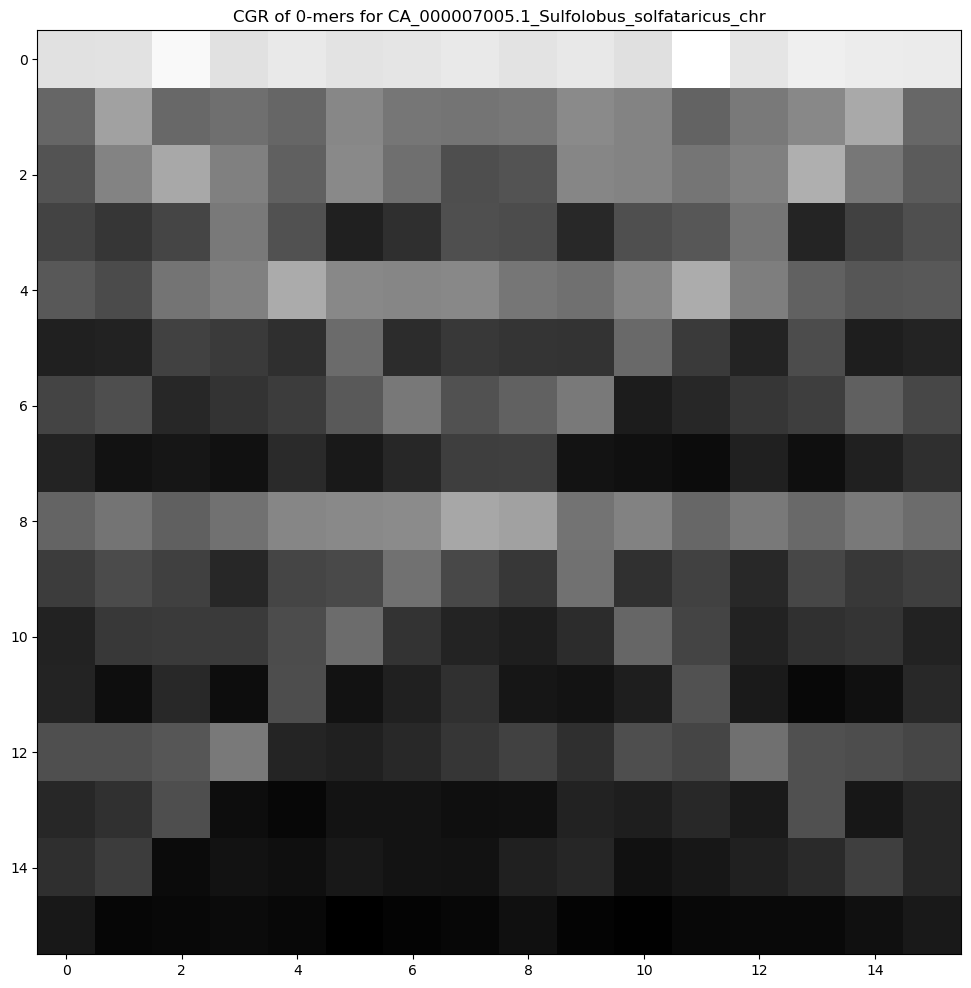

In [9]:
x = B.show_v2()

In [15]:
f = open("Temp/GCA_000007005.1_chr.fna")
s1 = f.read()
data_1 = "".join(s1.split("\n")[1:])

In [17]:
import sys
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from Bio import SeqIO


In [18]:
# defining cgr graph
# CGR_CENTER = (0.5, 0.5)
CGR_X_MAX = 1
CGR_Y_MAX = 1
CGR_X_MIN = 0
CGR_Y_MIN = 0
CGR_A = (CGR_X_MIN, CGR_Y_MIN)
CGR_T = (CGR_X_MAX, CGR_Y_MIN)
CGR_G = (CGR_X_MAX, CGR_Y_MAX)
CGR_C = (CGR_X_MIN, CGR_Y_MAX)
CGR_CENTER = ((CGR_X_MAX - CGR_Y_MIN) / 2, (CGR_Y_MAX - CGR_Y_MIN) / 2)


In [19]:
def empty_dict():
	"""
	None type return vessel for defaultdict
	:return:
	"""
	return None


CGR_DICT = defaultdict(
	empty_dict,
	[
		('A', CGR_A),  # Adenine
		('T', CGR_T),  # Thymine
		('G', CGR_G),  # Guanine
		('C', CGR_C),  # Cytosine
		('U', CGR_T),  # Uracil demethylated form of thymine
		('a', CGR_A),  # Adenine
		('t', CGR_T),  # Thymine
		('g', CGR_G),  # Guanine
		('c', CGR_C),  # Cytosine
		('u', CGR_T)  # Uracil/Thymine
		]
)


def fasta_reader(fasta):
	"""Return a generator with sequence description and sequence

	:param fasta: str filename
	"""
	# TODO: modify it to be capable of reading genebank etc
	flist = SeqIO.parse(fasta, "fasta")
	for i in flist:
		yield i.description, i.seq


def mk_cgr(seq):
	"""Generate cgr

	:param seq: list of nucleotide
	:return cgr: [['nt', (x, y)]] List[List[Tuple(float, float)]]
	"""
	cgr = []
	cgr_marker = CGR_CENTER[:
		]    # The center of square which serves as first marker
	for s in seq:
		cgr_corner = CGR_DICT[s]
		if cgr_corner:
			cgr_marker = (
				(cgr_corner[0] + cgr_marker[0]) / 2,
				(cgr_corner[1] + cgr_marker[1]) / 2
			)
			cgr.append([s, cgr_marker])
		else:
			sys.stderr.write("Bad Nucleotide: " + s + " \n")

	return cgr


def mk_plot(cgr, name, figid):
	"""Plotting the cgr
		:param cgr: [(A, (0.1, 0.1))]
		:param name: str
		:param figid: int
		:return dict: {'fignum': figid, 'title': name, 'fname': helper.slugify(name)}
	"""
	x_axis = [i[1][0] for i in cgr]
	y_axis = [i[1][1] for i in cgr]
	plt.figure(figid)
	plt.title("Chaos Game Representation\n" + name, wrap=True)
	# diagonal and vertical cross
	# plt.plot([x1, x2], [y1, y2])
	# plt.plot([0.5,0.5], [0,1], 'k-')
	plt.plot([CGR_CENTER[0], CGR_CENTER[0]], [0, CGR_Y_MAX], 'k-')

	# plt.plot([0,1], [0.5,0.5], 'k-')
	plt.plot([CGR_Y_MIN, CGR_X_MAX], [CGR_CENTER[1], CGR_CENTER[1]], 'k-')
	plt.scatter(x_axis, y_axis, alpha=0.5, marker='.')

	return {'fignum': figid, 'title': name, 'fname': slugify(name)}



def slugify(value):
	"""Purge bad char from given string based on
	django's slugify (template/defaultfilters.py)
	"""
	#value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore')
	value = re.sub(r'[^\w\s-]', '', value).strip()
	value = re.sub(r'[-\s]+', '-', value)
	return value


def write_figure(fig, output_dir, dpi=300):
	"""Write plot to png
	:param fig:  {'fignum':figid, 'title':name, 'fname':helper.slugify(name)}
	:param dpi: int dpi of output
	:param output_dir: str

	Usage:
		figures = [mk_plot(cgr) for cgr in all_cgr]
		for fig in figures:
			write_figure(fig, "/var/tmp/")
		The figid in the mk_plot's return dict must be present in plt.get_fignums()
	"""
	all_figid = plt.get_fignums()
	if fig['fignum'] not in all_figid:
		raise ValueError("Figure %i not present in figlist" % fig['fignum'])
	plt.figure(fig['fignum'])
	target_name = os.path.join(
		output_dir,
		slugify(fig['fname']) + ".png")
	plt.savefig(target_name, dpi=dpi)

In [20]:
cgr = mk_cgr(data_1)

{'fignum': 2, 'title': 'Test', 'fname': 'Test'}

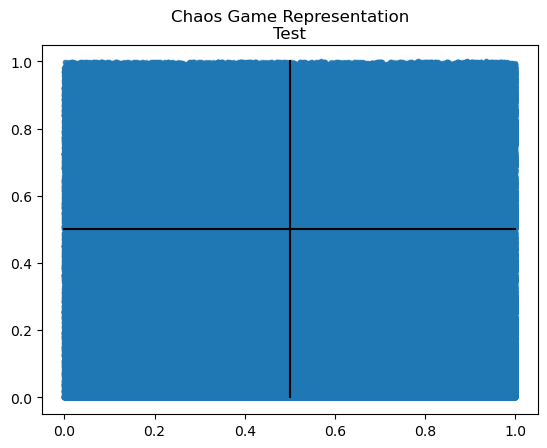

In [21]:
mk_plot(cgr, "Test", 2)